# Introduction

The goal of this project is to build a machine learning model that predicts which Tweets are about real disasters and which one's aren't. This sentiment classification task is important for helping first responders and news organizations detect and respond to real disasters quickly.

In [28]:
# Important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Cleaning and Preprocessing
from sklearn.utils import resample
import re
import nltk.corpus
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Model Building and Training
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate, StringLookup

# Data
The dataset was obtained from the Kaggle competition page [3]. The training dataset consists of 7,613 tweets each of which is hand classified with either a 1 representing a real disaster or 0 representing not-real disaster. The tweets each have a unique id and three features: text, keyword (possibly blank), and the location of the tweet (possibly blank). The tweet feature is a string which can be seen as a sequence of words. The test dataset contains 3,263 tweets with the same features but no labels. All the tweets are in English

In [5]:
train_df = pd.read_csv('train.csv')
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


In [6]:
test_df = pd.read_csv('test.csv')
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


# Exploratory Data Analysis
I will look at some example tweets and create some visualizations of the training dataset to inform my plan of creating a machine learning model.

In [16]:
sample_disaster_tweets = train_df[train_df['target']==1].head(5)
print(np.array(sample_disaster_tweets['text']))

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'
 'Forest fire near La Ronge Sask. Canada'
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"
 '13,000 people receive #wildfires evacuation orders in California '
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ']


The five sample tweets about real disasters all contain capital letters, punctuation, numbers, and stopwords. Typically, natural language processing removes all of these from the text before training the model. Two of the tweets, however, contain a hashtag with the name of of a natural disaster. It may be worth considering hashtags separately rather than removing them with other punctuation marks.

In [12]:
sample_nondisaster_tweets = train_df[train_df['target']==0]['text'].head(5)
print(np.array(sample_nondisaster_tweets))

["What's up man?" 'I love fruits' 'Summer is lovely' 'My car is so fast'
 'What a goooooooaaaaaal!!!!!!']


The five sample non-disaster tweets also contain capital letters, punctuation, and stop words. The non-disaster tweets seem pretty innocuous, with feature extraction my model should be able to classify tweets related to disasters. 

In [19]:
disaster_tweets_with_keywords = train_df[(train_df['target']==1)&(train_df['keyword'].notna())].head(5)
print(np.array(disaster_tweets_with_keywords['text']))
print(np.array(disaster_tweets_with_keywords['keyword']))
print(np.array(disaster_tweets_with_keywords['location']))

['@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C'
 '#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi'
 'INEC Office in Abia Set Ablaze - http://t.co/3ImaomknnA'
 'Barbados #Bridgetown JAMAICA \x89ÛÒ Two cars set ablaze: SANTA CRUZ \x89ÛÓ Head of the St Elizabeth Police Superintende...  http://t.co/wDUEaj8Q4J'
 'How the West was burned: Thousands of wildfires ablaze in California alone http://t.co/vl5TBR3wbr']
['ablaze' 'ablaze' 'ablaze' 'ablaze' 'ablaze']
['Birmingham' 'AFRICA' 'World Wide!!' nan 'GREENSBORO,NORTH CAROLINA']


In [20]:
nondisaster_tweets_with_keywords = train_df[(train_df['target']==0)&(train_df['keyword'].notna())].head(5)
print(np.array(nondisaster_tweets_with_keywords['text']))
print(np.array(nondisaster_tweets_with_keywords['keyword']))
print(np.array(nondisaster_tweets_with_keywords['location']))

['We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw'
 'Crying out for more! Set me ablaze'
 'On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N'
 "@PhDSquares #mufc they've built so much hype around new acquisitions but I doubt they will set the EPL ablaze this season."
 'Ablaze for you Lord :D']
['ablaze' 'ablaze' 'ablaze' 'ablaze' 'ablaze']
['Est. September 2012 - Bristol' 'Philadelphia, PA' 'London, UK'
 'Pretoria' 'Paranaque City']


Comparing disaster tweets with nondisaster tweets for the keyword 'ablaze' reveals more about necessary NLP steps and the differences between the two categories. Some of the tweets have URLs which will need to be removed as part of data cleaning. The disaster tweets in these examples contain location names in the text much more commonly. Both categories contain location features.

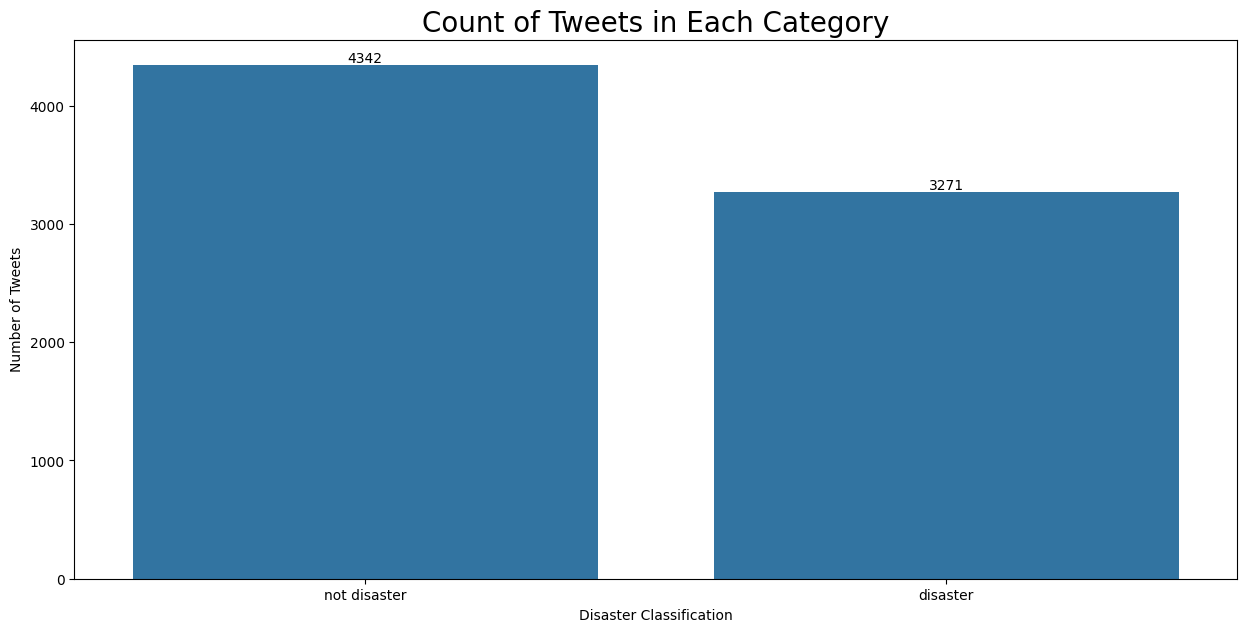

In [24]:
# Compare the frequency of the two categories
plt.figure(figsize=(15,7))
ax = sns.countplot(data=train_df , x=train_df['target'])

plt.xlabel('Disaster Classification')
plt.ylabel('Number of Tweets')
plt.xticks(ticks=[0,1], labels=['not disaster', 'disaster'])
plt.title('Count of Tweets in Each Category', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

The two categories are imbalanced. This could cause our model to be biased towards the not disaster category. It could also cause metrics such as accuracy to be misleading. To mitigate these issues the categories can be rebalanced using one of a few strategies:
* Resampling: undersample the majority class and/or oversample the minority class
* Synthetic Minority Oversampling Technique (SMOTE)  

SMOTE requires numerical data so it cannot be used for this task. Oversampling using simple observation duplication can lead to a model with poor generalization. While undersampling could remove valuable data it reduces training time and simplifies the model so it will be used to balance the classes.

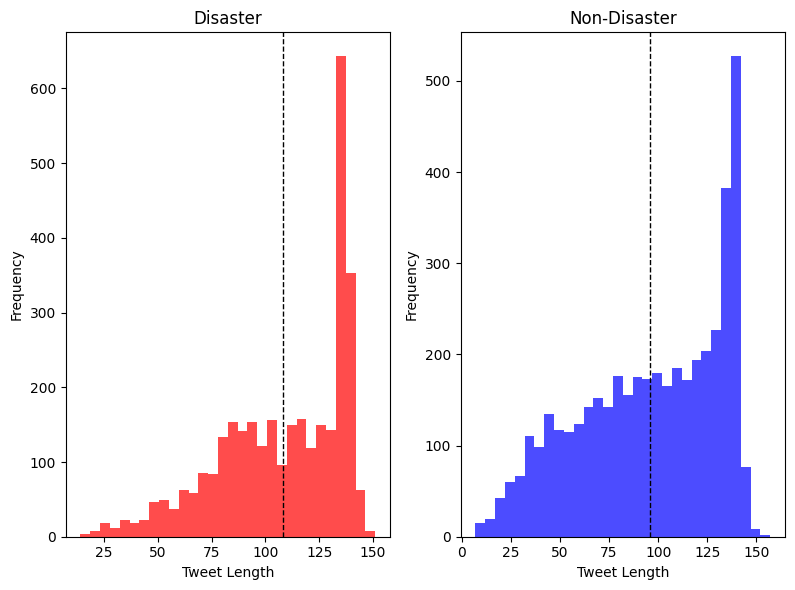

In [33]:
disaster_len = train_df[train_df['target']==1]['text'].apply(len)
mean_disaster_len = np.mean(disaster_len, axis=0)

nondisaster_len = train_df[train_df['target']==0]['text'].apply(len)
mean_nondisaster_len = np.mean(nondisaster_len, axis=0)

plt.figure(figsize=(12, 6))

# Plot histogram of disaster tweet lengths
plt.subplot(1, 3, 1)
plt.hist(disaster_len, bins=30, color='r', alpha=0.7)
plt.axvline(mean_disaster_len, color='k', linestyle='dashed', linewidth=1)
plt.title('Disaster')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')

# Plot histogram of nondisaster tweet lengths
plt.subplot(1, 3, 2)
plt.hist(nondisaster_len, bins=30, color='b', alpha=0.7)
plt.axvline(mean_nondisaster_len, color='k', linestyle='dashed', linewidth=1)
plt.title('Non-Disaster')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

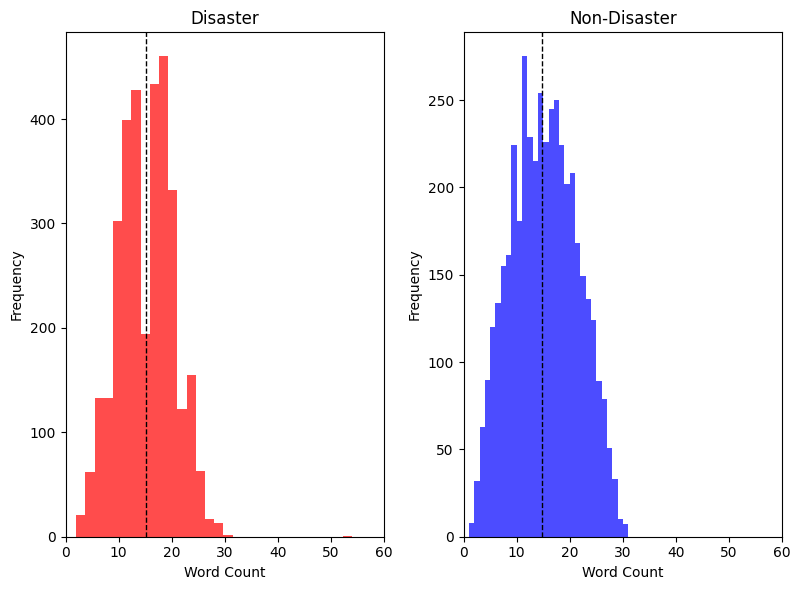

In [30]:
def get_word_count(tweet: str) -> int:
    return len(tweet.split(' '))

disaster_word_counts = train_df[train_df['target']==1]['text'].apply(get_word_count)
mean_disaster_word_count = np.mean(disaster_word_counts, axis=0)

nondisaster_word_counts = train_df[train_df['target']==0]['text'].apply(get_word_count)
mean_nondisaster_word_count = np.mean(nondisaster_word_counts, axis=0)

plt.figure(figsize=(12, 6))

# Plot histogram of disaster word counts
plt.subplot(1, 3, 1)
plt.hist(disaster_word_counts, bins=30, color='r', alpha=0.7)
plt.axvline(mean_disaster_word_count, color='k', linestyle='dashed', linewidth=1)
plt.title('Disaster')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.xlim(0, 60)

# Plot histogram of nondisaster word counts
plt.subplot(1, 3, 2)
plt.hist(nondisaster_word_counts, bins=30, color='b', alpha=0.7)
plt.axvline(mean_nondisaster_word_count, color='k', linestyle='dashed', linewidth=1)
plt.title('Non-Disaster')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.xlim(0, 60)

plt.tight_layout()
plt.show()

# Data Cleaning and Preprocessing

In [7]:
# Balance the classes
majority_class = train_df[train_df['target']==0]
minority_class = train_df[train_df['target']==1]

# undersample majority class
majority_class_downsampled = resample(majority_class,
                                      replace=False,
                                      n_samples=len(minority_class),
                                      random_state=42)

balanced_df = pd.concat([majority_class_downsampled, minority_class])

print(balanced_df['target'].value_counts())

0    3271
1    3271
Name: target, dtype: int64


In [8]:
def remove_punctuation(text: str) -> str:
    punctuation_free=re.sub(r'[^\w\s]+', '', text)
    return punctuation_free


def tokenize_text(text: str) -> str:
    tokens = text.split(' ')
    return tokens

def remove_stopwords(text: str) -> str:
    words_for_removal = stopwords.words('english')
    words_for_removal.append('')
    stopword_free = [word for word in text if word not in words_for_removal]
    return stopword_free

def remove_url(text: str) -> str:
    return re.sub(r'http\S+', '', text)

lowercase = train_df['text'].str.lower()
url_free = lowercase.apply(remove_url)
punctuation_free = url_free.apply(remove_punctuation)
tokenized_tweets = punctuation_free.apply(tokenize_text)
stopword_free = tokenized_tweets.apply(remove_stopwords)

stopword_free.head()

0    [deeds, reason, earthquake, may, allah, forgiv...
1        [forest, fire, near, la, ronge, sask, canada]
2    [residents, asked, shelter, place, notified, o...
3    [13000, people, receive, wildfires, evacuation...
4    [got, sent, photo, ruby, alaska, smoke, wildfi...
Name: text, dtype: object

Data cleaning so far has included punctuation removal, url removal, lowering all uppercase letters, and tokenization. For the final data cleaning step I will standardize the words used in each tweet. There are two commonly used options for standardization: stemming and lemmatization. Stemming reduces words to their base for example running -> run. Stemming can cause some words to lose their meaning for example available -> avail. For this project I will use lemmatization which also reduces words to their base but uses a pre-defined dictionary of words to ensure meaning is not lost. 

There are some other preprocessing steps such as HTML tag and rare word removal that are not necessary due to the context of the data (tweets).

In [9]:
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatizer(text: str) -> str:
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text
train_df['lemm_text'] = stopword_free.apply(lambda x: lemmatizer(x))
train_df['lemm_text'].head()

0    [deed, reason, earthquake, may, allah, forgive...
1        [forest, fire, near, la, ronge, sask, canada]
2    [resident, asked, shelter, place, notified, of...
3    [13000, people, receive, wildfire, evacuation,...
4    [got, sent, photo, ruby, alaska, smoke, wildfi...
Name: lemm_text, dtype: object

In [10]:
# Impute missing values for keyword and location
train_df['keyword'].fillna('missing', inplace=True)
train_df['location'].fillna('missing', inplace=True)

# Model Building and Training
I will use tensorflow's TextVectorization layer. This class has a standardize method but it cannot remove urls so I standardized the text myself prior to passing it to TextVectorization.  The required input is a sequence of words so I will join my lemmatized lists back into strings. I chose 30 words as the sequence length based on the graphs of word count seen above

In [20]:
train_copy = train_df.copy()
clean_text = train_copy['lemm_text'].apply(lambda x: ' '.join(x))
train_df['text'] = clean_text
train_df.drop(['lemm_text'], axis=1, inplace=True)
train_df.head()

,id,keyword,location,text,target
0,1,missing,missing,deed reason earthquake may allah forgive u,1
1,4,missing,missing,forest fire near la ronge sask canada,1
2,5,missing,missing,resident asked shelter place notified officer ...,1
3,6,missing,missing,13000 people receive wildfire evacuation order...,1
4,7,missing,missing,got sent photo ruby alaska smoke wildfire pour...,1


In [21]:
# Split training and validation datasets, test data is already in separate dataframe
X_train, X_val, y_train, y_val = train_test_split(
    train_df[['text', 'keyword', 'location']],
    train_df['target'],
    test_size=0.2,
    random_state=42
)

In [12]:
# Vectorize layer to vectorize the main text of the tweet
max_features = 10000
sequence_length = 30

vectorize_layer = layers.TextVectorization(
    standardize=None,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [22]:
# Create tensorflow dataset
train_text_ds = tf.data.Dataset.from_tensor_slices(X_train['text'].values)

# adapt vectorization layer to train set only to prevent data leakage
vectorize_layer.adapt(train_text_ds)

In [23]:
vectorized_train_text = vectorize_layer(X_train['text'].values)
vectorized_val_text = vectorize_layer(X_val['text'].values)

I chose StringLookup instead of other encoding options like one-hot encoding or tf-idf because I plan on feeding the output through an Embedding layer to create a dense vector representation

In [25]:
# Convert categorical string features into integer IDs
keyword_encoder = StringLookup(vocabulary=X_train['keyword'].unique(), mask_token=None)
location_encoder = StringLookup(vocabulary=X_train['location'].unique(), mask_token=None)

encoded_train_keyword = keyword_encoder(X_train['keyword'].values)
encoded_val_keyword = keyword_encoder(X_val['keyword'].values)

encoded_train_location = keyword_encoder(X_train['location'].values)
encoded_val_location = keyword_encoder(X_val['location'].values)

In [27]:
# Prepare train and validation datasets for model training
train_data = tf.data.Dataset.from_tensor_slices(({
    'text': vectorized_train_text,
    'keyword': encoded_train_keyword,
    'location': encoded_train_location
}, y_train))

val_data = tf.data.Dataset.from_tensor_slices(({
    'text': vectorized_val_text,
    'keyword': encoded_val_keyword,
    'location': encoded_val_location
}, y_val))

# Define batch size and shuffle for training
train_data = train_data.shuffle(buffer_size=len(X_train)).batch(32)
val_data = val_data.batch(32)

For my model architecture I considered Gated Recurrent Units (GRU) and Long Short-Term Memory units (LSTM) both of which are well suited to handling sequential data like text. GRU is more computationally efficient than LSTM so I will use GRU for processing the text portion of the dataset. In order to concatenate the the location and keyword embeddings with GRU output they need to be flattened to a 1D vector for compatibility. I use one fully integrated layer for processing the combined dataset (text, keyword, and location) because a fully connected layer is well suited to processing 1D vectors.

In [30]:
# Define inputs
text_input = layers.Input(shape=(sequence_length,), name='text')
keyword_input = layers.Input(shape=(1,), name='keyword')
location_input = layers.Input(shape=(1,), name='location')

# Embedding layers
embedding_layer = layers.Embedding(input_dim=max_features, output_dim=50, input_length=30)(text_input)

# Default parameters meet requirements for cuDNN implementation (GPU)
gru_layer = layers.GRU(
    64,
    return_sequences=False
)(embedding_layer)

keyword_embedding = layers.Embedding(input_dim=222, output_dim=50)(keyword_input)
location_embedding = layers.Embedding(input_dim=3342, output_dim=100)(location_input)

# Flatten embeddings
keyword_flattened = layers.Flatten()(keyword_embedding)
location_flattened = layers.Flatten()(location_embedding)

# Concatenate features
concatenated = layers.Concatenate()([gru_layer, keyword_flattened, location_flattened])

# Dense layers and output
dense_layer = layers.Dense(64, activation='relu')(concatenated)
output = layers.Dense(1, activation='sigmoid')(dense_layer)

# Define the model
model = Model(inputs=[text_input, keyword_input, location_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None, 30)]         0           []                               
                                                                                                  
 keyword (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 location (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 30, 50)       500000      ['text[0][0]']                   
                                                                                            

In [ ]:
# Training the model
history = model.fit(train_data, validation_data=val_data, epochs=10)

# Citations
[1] https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/#:~:text=There%20are%20several%20ways%20to,Minority%20Over%2Dsampling%20Technique).

[2] https://arxiv.org/abs/1910.01108

[3] https://www.kaggle.com/c/nlp-getting-started/overview

[4] https://keras.io/api/keras_nlp/models/distil_bert/

[5] https://medium.com/geekculture/hugging-face-distilbert-tensorflow-for-custom-text-classification-1ad4a49e26a7

[6] https://www.tensorflow.org/tutorials/keras/text_classification